In [1]:
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from constant import SUPPORTED_TASKS
from models.net import get_model
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt
from constant import NUM_TO_FOUR_CLASS
import numpy as np

In [2]:
candidate_24GHz = [
    '/home/zg34/datasets/drone_project/data/24GHz/drone/interval_0.25_wd_256/2024-03-01_11-07-57/0.png',
    '/home/zg34/datasets/drone_project/data/24GHz/bird/interval_0.25_wd_256/2024-02-06_10-26-29/59.png',
    '/home/zg34/datasets/drone_project/data/24GHz/cluster/interval_0.25_wd_256/2024-02-06_10-26-29/1.png',
    '/home/zg34/datasets/drone_project/data/24GHz/noise/interval_0.25_wd_256/2024-03-01_09-30-36/10.png'
]
candidate_94GHz = [
    '/home/zg34/datasets/drone_project/data/94GHz/drone/interval_0.25_wd_256/2024-03-01_10-45-45/21.png',
    '/home/zg34/datasets/drone_project/data/94GHz/bird/interval_0.25_wd_256/2024-02-06_10-24-28/70.png',
    '/home/zg34/datasets/drone_project/data/94GHz/cluster/interval_0.25_wd_256/2024-02-06_10-26-20/25.png',
    '/home/zg34/datasets/drone_project/data/94GHz/noise/interval_0.25_wd_256/2024-02-06_10-25-12/8.png'
]
candidate_207GHz = [
    '/home/zg34/datasets/drone_project/data/207GHz/drone/interval_0.25_wd_256/2024-03-01_09-54-10/0.png',
    '/home/zg34/datasets/drone_project/data/207GHz/bird/interval_0.25_wd_256/2024-02-06_10-24-23/67.png',
    '/home/zg34/datasets/drone_project/data/207GHz/cluster/interval_0.25_wd_256/2024-02-06_12-47-38/20.png',
    '/home/zg34/datasets/drone_project/data/207GHz/noise/interval_0.25_wd_256/2024-02-06_13-27-11/0.png'
]

In [3]:
task = 'four-class'
device = torch.device("cuda")
arch = 'resnet18'


def arch2layer(arch_name, model):
    if arch_name in ['resnet18', 'resnet50', 'resnext50_32x4d']:
        return [model.layer4[-1]]
    elif arch_name in ['convnext_base', 'convnext_tiny']:
        return [model.features[-1][-1].block]
    elif arch_name in ['efficientnet_v2_m', 'efficientnet_v2_s']:
        return [model.features[-1]]
    elif arch_name in ['alexnet']:
        return [model.features[10]]


net = get_model(arch, SUPPORTED_TASKS[task], False)
net.load_state_dict(torch.load(
    f'/home/zg34/Desktop/MathWorks-Radar-Drone-Project/logs/pth_models/{task}/{task}-{arch}.pth'))
net = net.eval().to(device)

In [4]:
cam = GradCAM(net, arch2layer(arch, net))

tf = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

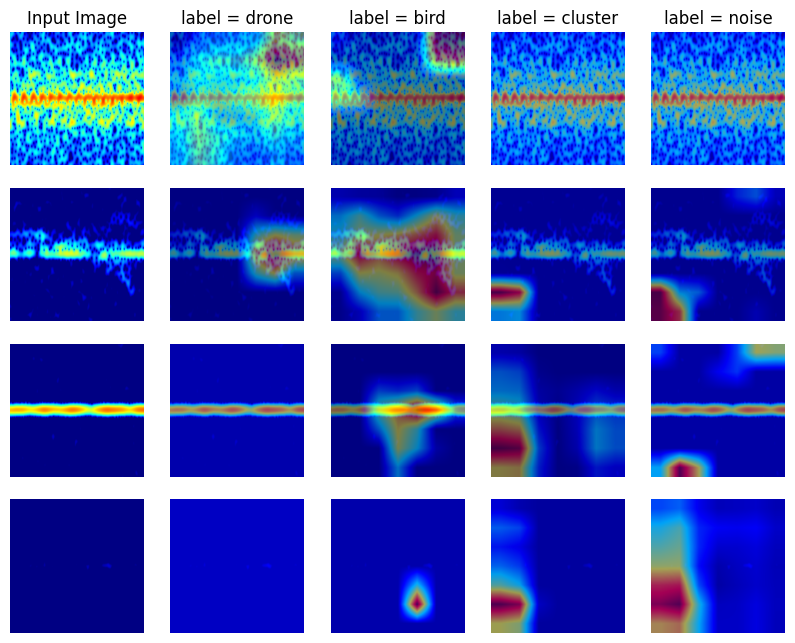

In [6]:
multi_fig, axis_list = plt.subplots(4, 5, figsize=(10, 8))
freq = 24
for label in range(4):
    ori_img = Image.open(eval(f'candidate_{freq}GHz')[label]).convert('RGB')
    img = tf(ori_img).unsqueeze(0)
    axis_list[label][0].imshow(ori_img)
    if label == 0:
        axis_list[label][0].set_title('Input Image')
    axis_list[label][0].axis('off')
    for idx, ax in enumerate(axis_list[label][1:]):
        target = [ClassifierOutputTarget(idx)]
        grayscale_cam = cam(input_tensor=img, targets=target)
        grayscale_cam = grayscale_cam[0, :]
        ori_img = img[0].permute(1, 2, 0).cpu().numpy()
        visualization = show_cam_on_image(ori_img, grayscale_cam, use_rgb=True)
        axis_list[label][idx + 1].imshow(visualization)
        if label == 0:
            axis_list[label][idx + 1].set_title(f'label = {NUM_TO_FOUR_CLASS[idx]}')
        axis_list[label][idx + 1].axis('off')
plt.subplots_adjust(hspace=0.05)
plt.show()